## Creation of mock galaxy catalog from Uchuu UM snapshot

Notebook creates a reasonably realistic LBG galaxy mock from data files of the DR2 Uchuu UM outputs for the snapshot at z = 2.95 (Uchuu_UM_z2p95_data*; https://skun.iaa.csic.es/SUsimulations/UchuuDR2/Uchuu_UM/SFR/).

The data(1/2/3) files, specifically, are used to make a selection of galaxies/halos and put them into redshift-space. They would be stored in ./data in this repository, but have not been since they are multiple 10s of Gigs, so you would need to download them yourself from the above link if you want to reproduce this notebook. The output of this notebook is saved in ./data in this repository.

_____________________________________________________________________________

The data structure of the files used in this notebook are as follows: 

---------------------- Description of galaxy properties ----------------------

*** Stored in a hdf5 file with a name ending in data1.h5 ***

id (int64)
ID of the galaxy. Share the ID with dark matter halo (appeared in Rockstar catalogs and
merger trees) in which galaxy resides if it is not an orphan. For orphans, the id is the last
ID in the halo catalog + 10^15 (number of snapshots as an orphan)

upid (int64)
ID of the largest dark matter halo in which galaxy resides (âˆ’1 for central halos)

Mvir (Msun/h, float32)
virial mass (Bryan & Norman 1998) of the dark matter halo

sm (Msun, float32)
true stellar mass of the galaxy

icl (Msun, float32)
true intracluster stellar mass inside the dark matter halo

sfr (Msun/yr, float32)
true star formation rate of the galaxy

obs_sm (Msun, float32)
observed stellar mass of the galaxy including random and systematic errors

obs_sfr (Msun/yr, float32)
observed star formation rate of the galaxy including random and systematic errors

obs_uv (M1500 AB, float32)
observed UV Magnitude

*** Stored in a hdf5 file with a name ending in data2.h5 ***

x,y,z (comoving Mpc/h, float32)
comoving x,y,z position of the galaxy


*** Stored in a hdf5 file with a name ending in data3.h5 ***

desc_id (int64)
ID of descendant halo (or -1 at z=0)

vx, vy, vz (peculiar km/s, float32)
peculiar velocity of the galaxy

Mpeak (Msun/h, float32)
halo peak historical mass (virial mass)

Vmax_Mpeak (km/s, float32)
maximum circular velocity when peak mass was achieved

vmax (km/s, float32)
maximum circular velocity of the dark matter halo

A_UV (mag, float32)
UV attenuation

_____________________________________________________________________________


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from hmf import MassFunction
from hmf import cosmo
import os
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
import latex
plt.rcParams['text.usetex'] = False
import sys
%matplotlib inline 

In [3]:
DATAdir = './data'


# Uchuu uses the following cosmology: 
# Planck2015 (table 4, rightmost column)
#Ω_m = 0.3089 Ω_L = 0.6911 h = 0.6774
#σ_8 = 0.8159 Ω_b = 0.0486 ns = 0.9667
#Linear Power Spectrum
#z_init = 127 (2LPT)
## Uchuu is 2000 Mpc/h on a side 
Om0 = 0.3089
h = 0.6774
H0 = 100*h
z_sim = 2.95
Lbox = 2000 # Mpc/h
ns = 0.9667
sigma8 = 0.8159
Ob0 = 0.0486
Tcmb0 = 2.718
cosmoFLCDM=FlatLambdaCDM(H0=H0,Om0=Om0,Ob0=Ob0,Tcmb0=Tcmb0)
Dv = cosmoFLCDM.comoving_distance(z_sim).value*h
arclen = Lbox/20/Dv*180./np.pi # degrees
area = arclen**2 # deg^2 surface area of 100x100 Mpc/h patch of box length, better SAA
AREA = area*400*60**2 # there are 400 100x100 patches in the 2000x2000 surface of a side of the box. Assume DAA.
VOL=2000.**3

Nbins = 100
LOS = 'z'
CUT = 'VLTS'
SAVEhaloCUT = 'false'

In [4]:
# Data1 ID,upid,Mvir,sm,icl,sfr,obs_sm,obs_sfr,obs_uv 
data1 =   h5py.File(DATAdir+'/Uchuu_UM_z2p95_data1.h5','r')
# Data2 x,y,z
data2 = h5py.File(DATAdir+'/Uchuu_UM_z2p95_data2.h5','r')
# Data3 ID,vx,vy,vz,Mpeak,Vmax_Mpeak,vmax,A_UV
data3 =  h5py.File(DATAdir+'/Uchuu_UM_z2p95_data3.h5','r')

ID_UM = data1['id'][:]
xUM = data2['x'][:]
yUM = data2['y'][:]
zUM = data2['z'][:]
vxUM = data3['vx'][:]
vyUM = data3['vy'][:]
vzUM = data3['vz'][:]
obs_sfrUM = data1['obs_sfr'][:]
obs_smUM = data1['obs_sm'][:]

cut = obs_sfrUM > 0
ID_UM = ID_UM[cut]
xUM = xUM[cut]
yUM = yUM[cut]
zUM = zUM[cut]
vxUM = vxUM[cut]
vyUM = vyUM[cut]
vzUM = vzUM[cut]
obs_sfrUM = obs_sfrUM[cut]
obs_smUM = obs_smUM[cut]

In [5]:
SFRbins=np.linspace(obs_sfrUM.min(),obs_sfrUM.max(),Nbins)
SFRcount,SFRedge = np.histogram(obs_sfrUM,bins=SFRbins)
SFRwid = SFRedge[1:]-SFRedge[:-1]
SFRcen = SFRedge[:-1]+SFRwid/2.
SFRden = SFRcount/SFRwid/VOL


SMbins=np.linspace(np.log10(obs_smUM).min(),np.log10(obs_smUM).max(),Nbins)
SMcount,SMedge = np.histogram(np.log10(obs_smUM),bins=SMbins)
SMwid = SMedge[1:]-SMedge[:-1]
SMcen = SMedge[:-1]+SMwid/2.
SMden = SMcount/SMwid/VOL

obs_ssfrUM =np.log10(obs_sfrUM/obs_smUM)
sSFRbins=np.linspace(obs_ssfrUM.min(),obs_ssfrUM.max(),Nbins)
sSFRcount,sSFRedge = np.histogram(obs_ssfrUM,bins=sSFRbins)
sSFRwid = sSFRedge[1:]-sSFRedge[:-1]
sSFRcen = sSFRedge[:-1]+sSFRwid/2.
sSFRden = sSFRcount/sSFRwid/VOL

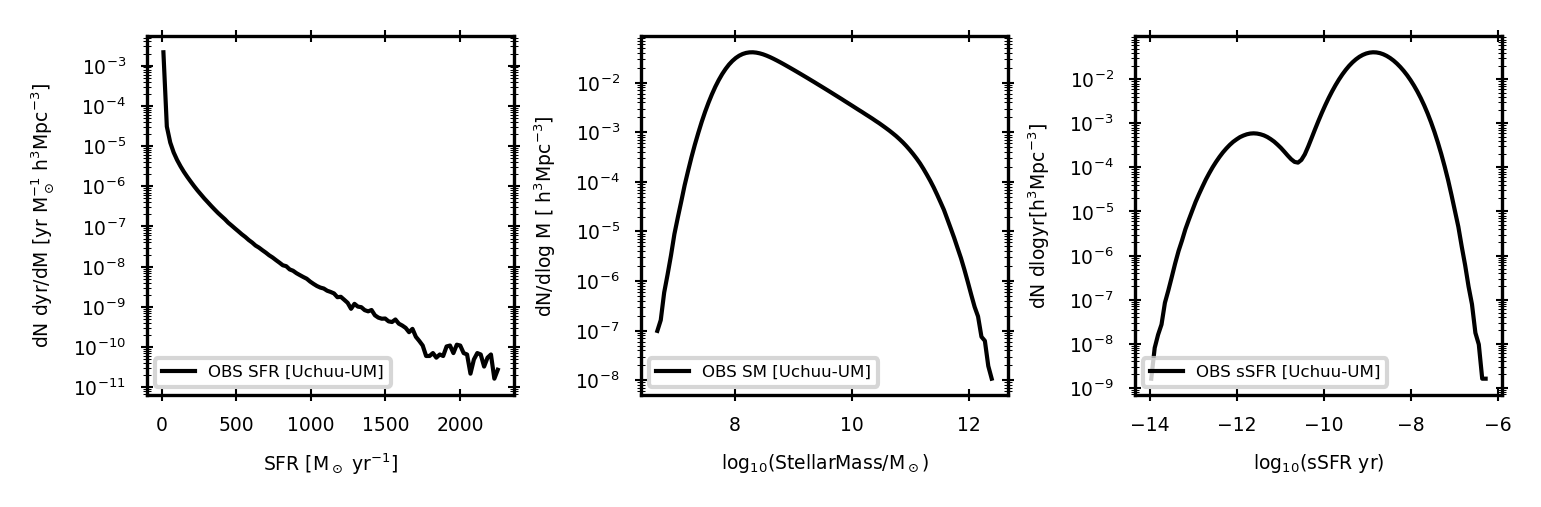

In [6]:
fig, axs = plt.subplots(1,3, sharex=False,sharey=False,dpi=300,figsize=(5.2,1.6))
fig.subplots_adjust(top=0.95,bottom=0.202,left=0.098,right=0.967,wspace=0.343,hspace=0.0)
(ax1,ax2,ax3) = axs

ax1.plot(SFRcen,SFRden,color='k',lw=1.0,label=r'OBS SFR [Uchuu-UM]')
ax2.plot(SMcen,SMden,color='k',lw=1.0,label=r'OBS SM [Uchuu-UM]')
ax3.plot(sSFRcen,sSFRden,color='k',lw=1.0,label=r'OBS sSFR [Uchuu-UM]')

ax1.set_yscale('log')
ax1.set_xlabel(r"$\rm SFR~[\rm M_\odot~yr^{-1}]$",fontsize=4.5)
ax1.set_ylabel(r"$\rm dN~dyr/dM~[\rm yr~M_\odot^{-1}~h^{3}{\rm Mpc}^{-3}]$",fontsize=4.5)
ax1.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax1.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax1.legend(loc='lower left',fontsize=4)

ax2.set_yscale('log')
ax2.set_xlabel(r"$\rm log_{10}(Stellar Mass/M_\odot)$",fontsize=4.5)
ax2.set_ylabel(r"$\rm dN/dlog~M~[\rm ~h^{3}{\rm Mpc}^{-3}]$",fontsize=4.5)
ax2.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax2.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax2.legend(loc='lower left',fontsize=4)

ax3.set_yscale('log')
ax3.set_xlabel(r"$\rm log_{10}(sSFR~yr)$",fontsize=4.5)
ax3.set_ylabel(r"$\rm dN~dlogyr [h^{3}{\rm Mpc}^{-3}]$",fontsize=4.5)
ax3.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax3.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax3.legend(loc='lower left',fontsize=4)


plt.show()

In [7]:

SFRcdf = np.zeros((len(SFRcen)))
for i in range(0,len(SFRcen)):
   SFRcdf[i] = len(obs_sfrUM[obs_sfrUM>=SFRbins[i]])/AREA

logsmUM = np.log10(obs_smUM)
SMcdf = np.zeros(len(SMcen))
for i in range(0,len(SMcen)):
   SMcdf[i] = len(logsmUM[logsmUM>=SMbins[i]])/AREA

sSFRcdf = np.zeros((len(sSFRcen)))
for i in range(0,len(sSFRcen)):
   sSFRcdf[i] = len(obs_ssfrUM[obs_ssfrUM>=sSFRbins[i]])/AREA


if CUT=='VLTS':
    SFRcenCUT = SFRcen[SFRcdf>=0.2][-1]
    SMcenCUT = SMcen[SMcdf>=0.2][-1]
    sSFRcenCUT = sSFRcen[sSFRcdf>0.2][-1]


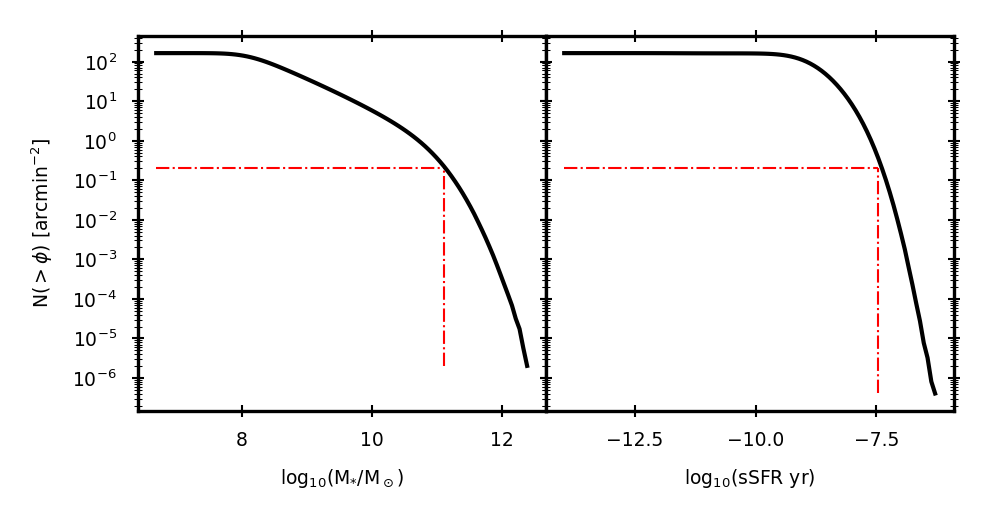

In [8]:
fig, axs = plt.subplots(1,2, sharex=False,sharey=True,dpi=300,figsize=(3.2,1.6))
fig.subplots_adjust(top=0.95,bottom=0.17,left=0.117,right=0.967,wspace=0.0,hspace=0.0)
(ax1,ax2)=axs

#ax1.plot(SFRcen,SFRcdf,color='k',lw=1,ls='-')
ax1.plot(SMcen,SMcdf,color='k',lw=1,ls='-')
ax2.plot(sSFRcen,sSFRcdf,color='k',lw=1,ls='-')

#ax1.plot((SFRcen.min(),SFRcenCUT),(0.2,0.2),zorder=0,lw=0.5,ls='-.',color='r')
#ax1.plot((SFRcenCUT,SFRcenCUT),(SFRcdf.min(),0.2),zorder=0,lw=0.5,ls='-.',color='r')
ax1.plot((SMcen.min(),SMcenCUT),(0.2,0.2),zorder=0,lw=0.5,ls='-.',color='r')
ax1.plot((SMcenCUT,SMcenCUT),(SMcdf.min(),0.2),zorder=0,lw=0.5,ls='-.',color='r')
ax2.plot((sSFRcen.min(),sSFRcenCUT),(0.2,0.2),zorder=0,lw=0.5,ls='-.',color='r')
ax2.plot((sSFRcenCUT,sSFRcenCUT),(sSFRcdf.min(),0.2),zorder=0,lw=0.5,ls='-.',color='r')


#ax1.set_ylim(SFRcdf.min(),SFRcdf.max())
#ax1.set_xlim(SMcen.min(),SMcen.max())
#ax2.set_xlim(sSFRcen.min(),sSFRcen.max())
ax1.set_ylabel(r'N($>\phi$) [arcmin$^{-2}$]',fontsize=4.5)
#ax1.set_xlabel(r'$\rm sSFR [M_\odot~yr^{-1}]$',fontsize=4.5)
ax1.set_xlabel(r'$\rm log_{10}(M_{*}/M_\odot)$',fontsize=4.5)
ax2.set_xlabel(r'$\rm log_{10}(sSFR~yr)$',fontsize=4.5)
ax1.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax1.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax2.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax2.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
#ax3.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
#ax3.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax1.set_yscale('log')
#ax2.set_yscale('log')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
#ax3.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()


The red dash-dot line shows the value on the x-axis at which all galaxies above this value should be included in the catalog to match the expected surface density of LBGs on the y-axis (0.2 per arcmin^2). This is a cut on abundance. It might make sense to choose the galaxies with the highest sSFR but not necessary the galaxies with the highest stellar mass. We will proceed with the sSFR selection.

In [11]:
cut = logsmUM>=SMcenCUT
xCsm = xUM[cut]
yCsm = yUM[cut]
zCsm = zUM[cut]
vxCsm = vxUM[cut]
vyCsm = vyUM[cut]
vzCsm = vzUM[cut]

cut = obs_ssfrUM>=sSFRcenCUT
xCssfr = xUM[cut]
yCssfr = yUM[cut]
zCssfr = zUM[cut]
vxCssfr = vxUM[cut]
vyCssfr = vyUM[cut]
vzCssfr = vzUM[cut]

aa=1./(1.+z_sim)
sf=0.01/np.sqrt(Om0/aa+(1-Om0)*aa**2) # Calculates H(z)
# zsft=z+vz*sf

if LOS == 'x':
    xCsm = xCsm + vxCsm*sf
    xCssfr = xCssfr + vxCssfr*sf
if LOS == 'y':
    yCsm = yCsm + vyCsm*sf
    yCssfr = yCssfr + vyCssfr*sf
if LOS == 'z':
    zCsm = zCsm + vzCsm*sf
    zCssfr = zCssfr + vzCssfr*sf


coordsSM = np.vstack((xCsm,yCsm,zCsm)).T
coordsSSFR= np.vstack((xCssfr,yCssfr,zCssfr)).T
if SAVEhaloCUT:
    #np.savetxt('{}/Uchuu_xyz_SM_{}_sftz.dat'.format(DATAdir,CUT),coordsSM,fmt='%5.5f')
    np.savetxt('{}/Uchuu_xyz_sSFR_{}_sftz.dat'.format(DATAdir,CUT),coordsSSFR,fmt='%5.5f')